# Uplimit Practice A/B Testing Course: Project 4

## Setup

Load the data into Google collab

In [1]:
!pip install -U --no-cache-dir gdown --pre
!gdown --no-cookies --fuzzy https://drive.google.com/file/d/1kQ_HJwMFW34rjO1N8hwYUR43BsT8Hgva/view?usp=sharing
!gdown --no-cookies --fuzzy https://drive.google.com/file/d/1DgoY76t7I9rOoViBtSDvsFiUnD5m3yrp/view?usp=sharing
!gdown --no-cookies --fuzzy https://drive.google.com/file/d/1DTyuXevACSNJHvNRvZYi1edR1foGrGEZ/view?usp=sharing

Downloading...
From: https://drive.google.com/uc?id=1kQ_HJwMFW34rjO1N8hwYUR43BsT8Hgva
To: /content/dataset_price_multi.csv
100% 2.45M/2.45M [00:00<00:00, 18.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1DgoY76t7I9rOoViBtSDvsFiUnD5m3yrp
To: /content/dataset_price_algo.csv
100% 2.34M/2.34M [00:00<00:00, 17.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1DTyuXevACSNJHvNRvZYi1edR1foGrGEZ
To: /content/dataset_checkbox_discount.csv
100% 2.34M/2.34M [00:00<00:00, 18.1MB/s]


Load the libraries.

In [2]:
# Lirbary basics
import numpy as np
import pandas as pd
import scipy.stats as stats # For pvalue
import math # For power calculation

Helper function to get the 95% confidence interval. Inputs:
* Mean treatment - average conversion rate of the treatment group
* Mean control - average conversion rate of the control group
* N treatment - number of samples in the treatment group
* N control - number of samples in the control group
* ci = The width of the confidence interval. 0.95 by default

You can read more about the math behind the confidence interval function [here](https://s3.amazonaws.com/assets.datacamp.com/production/course_6165/slides/chapter4.pdf).

In [3]:
def get_ci(mean_treatment, mean_control, n_treatment, n_control, ci = 0.95):
    sd = ((mean_treatment * (1 - mean_treatment)) / n_treatment + (mean_control * (1 - mean_control)) / n_control)**0.5
    lift = mean_treatment - mean_control
    val = stats.norm.isf((1 - ci) / 2)
    lwr_bnd = lift - val * sd
    upr_bnd = lift + val * sd
    return((lwr_bnd, upr_bnd))

Helper function to calcuate the results. It will compute and return the relative and absolute lift between variant and control, p-value, and lower and upper bound for the 95% confidence interval. A standard two-sided t-test with an assumption of equal variance is used to compute the p-value.

Inputs:
* DF = data frame with each row being a sample in the A/B test. It must have a column called "variant" that takes on the value "control" or "treatment
* Metric = the metric we want to evaluate. This must be 'new_active_listings','new_booked_listings', or 'cancellations'). If it is not one of these values an "invalid metric" error will be thrown.

In [4]:
def calculate_results(df,metric):
    # Check
    if metric not in ('new_active_listing','new_booked_listing','new_cancelled_listing','bookings_4w'):
        raise Exception("Invalid metric")

    # Values and relative difference
    mean_control = df.loc[df['variant'] == "control",metric].mean()
    mean_treatment = df.loc[df['variant'] != "control",metric].mean() # Adjusting to allow for any treatment name

    abs_diff = mean_treatment-mean_control
    rel_diff = (mean_treatment-mean_control)/mean_control

    # P-Value -- two-sided ttest, assumes normal distribution
    data_group1 = list(df.query('variant == "control"')[metric])
    data_group2 = list(df.query('variant != "control"')[metric])

    results = stats.ttest_ind(a=data_group1, b=data_group2, equal_var=True)
    pvaue = results.pvalue

    # 95% confidence intervals
    [ci_low, ci_high] = get_ci(mean_treatment,mean_control,len(data_group2),len(data_group1),.95)
    ci_low = ci_low/mean_control
    ci_high = ci_high/mean_control

    return(rel_diff,abs_diff,results.pvalue,ci_low,ci_high)

## Background

TinyTraveler's rockstar data scientist- you made it to the final week! The engineers and Max are all rolling now, so you might need to think about running multiple tests at the same time.

Like in past weeks, we'll be designing and analyzing A/B tests based on the course's projects and material.

## Task 1: Two changes. One page. What should we do?

The team has two ideas they're optimistic about:

_Test A: Price recommendation algorithm update_: Last week, the team successfully implemented a version of the recommendation algorithm, resulting in a stat-sig lift to new booked listings (yay!). However, the team hypothesizes that the prices are still a bit high on average, so they tweaked the algorithm to be a bit more conservative and want to try this out.

_Test B: First booking discount_: Pricing has proven to be a successful lever for increasing new booked listings, so the team held a brainstorm to generate ideas other than tweaking the recommendation algorithm. Hosts might be willing to reduce the price for their first booking only. The team wants to test out a checkbox which will allow hosts to opt-in to a 10% discount on the first booking. See the design for the checkbox test below.

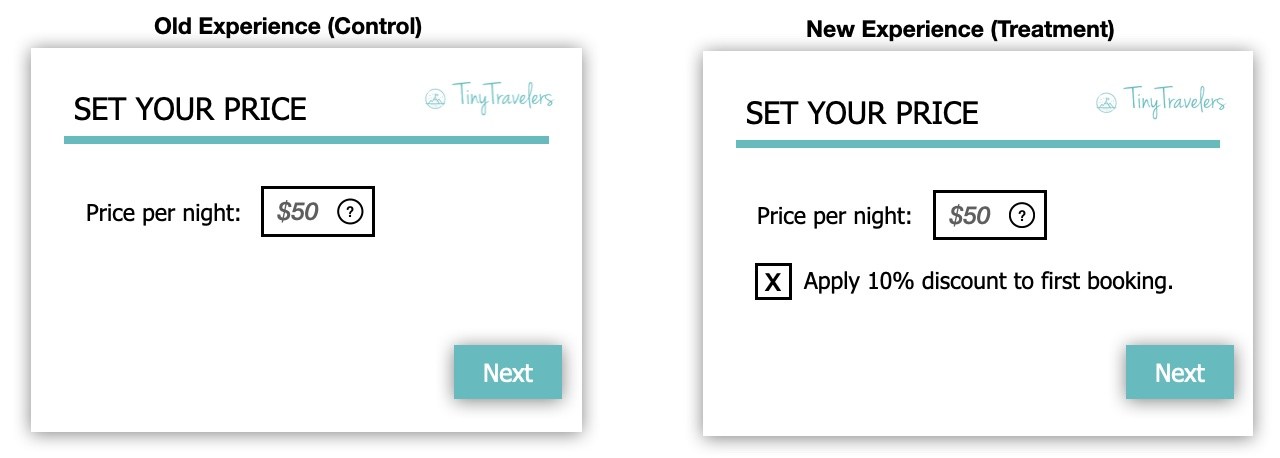

Unfortunately, both of these changes are on the same page in the onboarding flow. So they need your help figuring out how to proceed.

### Task 1.a. Test structure options

This week we discussed 3 [possible approaches](https://corise.com/course/practical-ab-testing/v2/enrollment/enrollment_clfveg8uy01o712ecb49scfbz/module/module_cli1vlhms01rx129gc77v9nou) to measuring the impact of two tests:

* Waiting - Run one after another.
* Orthogonal - Run them at the same time with different randomizations.
* Split traffic - Run a multi-variant test

Which of the above the options do you think should be considered and not considered in this case? Which one would you recommend?

## **ANSWER 1A**
It is difficult to know which method to recommend without having constrains or requirements from the business. With that said, I tend to favour the **orthogonal** approach when running concurrent tests since it:
- Optimizes power and time
- Mitigates dependency issues i.e. a bug in one of the implementations can be a major productivity issue
- Interaction effects between concurrent tests can be deduced after that fact.

Furthermore, in this case having both a *better* pricing algorithm AND the first booking discount is not an undesirable interaction in my opinion.

Another option for this A/B test would be to simply wait and test one feature after the other but I dislike this for 2 reasons:
1. It is considerably slower
2. Less interaction effects are measured since the order in which we A/B test these product changes affects our analysis conclusios.

A final alternative would be to split traffic and run a multi-variant test. From my perspective, this approach does not offer much benefit when compared to the orthogonal test since we:
1. Reduce power
2. Introduce dependencies due to how we've randomized i.e. if one treatment is buggy, we'll either have to start the whole test again or abandon that variant

## Task 2. Test one way

**Warning** this gives away the answer to task 1.a. so please complete that first :)

**Test design - FYI :)**

After discussing the options with Max, you decide to proceed with an _orthogonal test_. The plan is to run each as a 50/50 test and then check for interaction in the analysis stage.

For both the algorithm and discount tests, you've aligned on the triggering moment being when someone clicks "next" on the previous page in the onboarding flow. So the hypotheses you're working with are:

* _Algorithm update_: If we update the price recommendation algorithm, new booked listings (NBL) will increase because the new price will appeal more to guests.

* _First booking discount_: If we add a checkbox allowing hosts to opt-in to discount their first booking, NBL will increase because the price will appeal more to guests.

Since you already ran a test on this page last week and the traffic is the same (~4K new users arriving on the page per day with an NBL conversion rate of 40%), the power analysis you did there holds. Max is OK with targeting a 2.1% relative lift so that this test will run for 28 days.

The test has run and the results are in! Please analyze the data provided, and share a summary and recommendation on how to proceed. We'll break this down into 3 sub-tasks.

### Task 2.a. Analyze the tests individually

In [5]:
from scipy.stats import chi2_contingency

def ab_test_chi2(data_column):
    """
    Performs a Chi-squared test on A/B testing data where the groups are labeled 'control' and 'treatment'.

    :param data_column: Pandas Series with two possible values ('control' and 'treatment').
    :return: The p-value from the Chi-squared test.
    """

    if not isinstance(data_column, pd.Series):
        raise ValueError("The data_column must be a Pandas Series.")

    # Mapping 'control' to 0 and 'treatment' to 1
    data_column_mapped = data_column.map({'control': 0, 'treatment': 1})

    if data_column_mapped.isnull().any():
        raise ValueError("The data_column must contain only 'control' and 'treatment' values.")

    # Count the occurrences of control (0) and treatment (1)
    observed_counts = data_column_mapped.value_counts()

    # Assuming a 50/50 split for the expected counts
    total_count = observed_counts.sum()
    expected_counts = pd.Series([total_count / 2, total_count / 2], index=observed_counts.index)

    # Perform the Chi-squared test
    chi2, p_value, _, _ = chi2_contingency([observed_counts, expected_counts])

    return p_value, total_count, observed_counts


In [6]:
import pandas as pd
import numpy as np
from scipy import stats

def custom_calculate_results(df, metric, dimensions=None):
    # Check if the metric is valid
    if metric not in ('new_active_listing', 'new_booked_listing', 'new_cancelled_listing'):
        raise Exception("Invalid metric")

    results = {'Dimension': [], 'Level': [], 'Relative Difference': [], 'Absolute Difference': [], 'P-Value': [], '95% CI Lower': [], '95% CI Upper': []}

    # Define a function to calculate the metrics
    def custom_calculate_metrics(df_subset):
        mean_control = df_subset.loc[df_subset['variant'] == "control", metric].mean()
        mean_treatment = df_subset.loc[df_subset['variant'] == "treatment", metric].mean()

        abs_diff = mean_treatment - mean_control
        rel_diff = (mean_treatment - mean_control) / mean_control

        # P-Value -- two-sided ttest, assumes normal distribution
        data_group1 = df_subset[df_subset['variant'] == "control"][metric]
        data_group2 = df_subset[df_subset['variant'] == "treatment"][metric]

        results = stats.ttest_ind(a=data_group1, b=data_group2, equal_var=True)
        pvalue = results.pvalue

        # 95% confidence intervals
        ci_low, ci_high = get_ci(mean_treatment, mean_control, len(data_group2), len(data_group1), 0.95)
        ci_low = ci_low / mean_control
        ci_high = ci_high / mean_control

        return rel_diff, abs_diff, pvalue, ci_low, ci_high

    # If no dimensions are given, calculate for the entire dataframe
    if not dimensions:
        results['Dimension'].append('Overall')
        results['Level'].append('')
        rel_diff, abs_diff, pvalue, ci_low, ci_high = custom_calculate_metrics(df)
        results['Relative Difference'].append(rel_diff)
        results['Absolute Difference'].append(abs_diff)
        results['P-Value'].append(pvalue)
        results['95% CI Lower'].append(ci_low)
        results['95% CI Upper'].append(ci_high)
    else:
        # Calculate for each dimension
        for dimension in dimensions:
            for level in df[dimension].unique():
                df_subset = df[df[dimension] == level]
                results['Dimension'].append(dimension)
                results['Level'].append(level)
                rel_diff, abs_diff, pvalue, ci_low, ci_high = custom_calculate_metrics(df_subset)
                results['Relative Difference'].append(rel_diff)
                results['Absolute Difference'].append(abs_diff)
                results['P-Value'].append(pvalue)
                results['95% CI Lower'].append(ci_low)
                results['95% CI Upper'].append(ci_high)

    # Convert the results to a Pandas DataFrame
    df_results = pd.DataFrame(results)

    return df_results


First, treat each test as independent and analyze them as you would normally.

In [7]:
df_price_algo = pd.read_csv('/content/dataset_price_algo.csv')
df_checkbox_discount = pd.read_csv('/content/dataset_checkbox_discount.csv')

### Check for assignment imbalance

In [8]:
### ALGO
p_value, total_count, observed_counts = ab_test_chi2(df_price_algo['variant'])
print(f"Total Count: {total_count}")
print(f"Observed Count:\n{observed_counts}")
print(f"Chi-squared test p-value: {p_value}")

Total Count: 111535
Observed Count:
1    55776
0    55759
Name: variant, dtype: int64
Chi-squared test p-value: 0.9746640184324598


In [9]:
### CHECKBOX
p_value, total_count, observed_counts = ab_test_chi2(df_checkbox_discount['variant'])
print(f"Total Count: {total_count}")
print(f"Observed Count:\n{observed_counts}")
print(f"Chi-squared test p-value: {p_value}")

Total Count: 111535
Observed Count:
0    55786
1    55749
Name: variant, dtype: int64
Chi-squared test p-value: 0.9409268428778917


### Check target metric results

In [10]:
### ALGO
metric = 'new_booked_listing'
print(f"Analysis of {metric}")
pd.DataFrame(calculate_results(df_price_algo, metric),
             index=['rel diff','abs diff','pvalue','ci low','ci high']).T

Analysis of new_booked_listing


,rel diff,abs diff,pvalue,ci low,ci high
0,-0.047622,-0.009203,0.000086,-0.071383,-0.023861


In [11]:
### CHECKBOX
metric = 'new_booked_listing'
print(f"Analysis of {metric}")
pd.DataFrame(calculate_results(df_checkbox_discount, metric),
             index=['rel diff','abs diff','pvalue','ci low','ci high']).T

Analysis of new_booked_listing


,rel diff,abs diff,pvalue,ci low,ci high
0,0.03118,0.005792,0.013436,0.006459,0.055901


### Check guardrail

In [12]:
### ALGO
metric = 'new_cancelled_listing'
print(f"Analysis of {metric}")
pd.DataFrame(calculate_results(df_price_algo, metric),
             index=['rel diff','abs diff','pvalue','ci low','ci high']).T

Analysis of new_cancelled_listing


,rel diff,abs diff,pvalue,ci low,ci high
0,-0.000305,-0.000003,0.996056,-0.121153,0.120543


In [13]:
### CHECKBOX
metric = 'new_cancelled_listing'
print(f"Analysis of {metric}")
pd.DataFrame(calculate_results(df_checkbox_discount, metric),
             index=['rel diff','abs diff','pvalue','ci low','ci high']).T

Analysis of new_cancelled_listing


,rel diff,abs diff,pvalue,ci low,ci high
0,-0.058966,-0.000568,0.324516,-0.176269,0.058336


## **ANSWER 2A**
When analyzed individually:
- The checkbox feature has a positive 3% relative uplift on NBL;
- Whilst our new pricing algorithm is causing a 5% decrease in NBL

### Task 2.b. Check for interactions

Now that we know how the tests performed individually, it's time to see if there was an interaction effect. In other words, is the observed effect for Test A different for users in Test B's control vs Test B's treatment? And vice-versa.

For simplicity, assume that the two tests started and ended at the exact same time, with the same triggering moment. So every user should be in both tests, and the conversion events should match (e.g. someone who had an NBL in test A will also have an NBL in test B).

Now we want to check to see if there is an interaction. When a user of Test A is in the treatment of Test B, are the results different vs when they were in the control? And vice versa.

#### Do it on your own!

If you want to do it on your own but need some help with Pandas, here are some helpful resources:
* [Cheat sheet 1 pager](https://pandas.pydata.org/Pandas_Cheat_Sheet.pdf)
* [Cheet sheet multipager](https://www.webpages.uidaho.edu/~stevel/cheatsheets/Pandas%20DataFrame%20Notes_12pages.pdf)
* [Guide](https://medium.com/analytics-vidhya/top-20-pandas-functions-which-are-commonly-used-for-exploratory-data-analysis-3cb817a60f46)

In [14]:
def prepare_dataframe(df, new_variant_col):
    """
    Prepares a DataFrame for joining by creating a new variant column,
    dropping the old variant column, and setting the index.

    :param df: The DataFrame to prepare.
    :param new_variant_col: Name for the new variant column.
    :return: A prepared DataFrame.
    """
    df_prepared = df.copy()
    df_prepared.loc[df_prepared['variant'] == 'control', new_variant_col] = 'control'
    df_prepared.loc[df_prepared['variant'] == 'treatment', new_variant_col] = 'treatment'
    df_prepared.drop(columns='variant', inplace=True)
    df_prepared.set_index('id_user', inplace=True)
    return df_prepared

def join_dataframes(df1, df2, common_columns):
    """
    Joins two prepared DataFrames.

    :param df1: The first DataFrame.
    :param df2: The second DataFrame, from which common columns are dropped.
    :param common_columns: List of columns to drop from the second DataFrame.
    :return: A DataFrame resulting from the outer join of df1 and df2.
    """
    df2_dropped = df2.drop(columns=common_columns)
    df_combined = df1.join(df2_dropped, on='id_user', how='outer')
    return df_combined

# Example usage
df_A_prepared = prepare_dataframe(df_price_algo, 'variant_algo')
df_B_prepared = prepare_dataframe(df_checkbox_discount, 'variant_checkbox')

common_cols = ['new_active_listing', 'new_booked_listing', 'new_cancelled_listing']
df_combined = join_dataframes(df_A_prepared, df_B_prepared, common_cols)


In [15]:
df_combined

,new_active_listing,new_booked_listing,new_cancelled_listing,variant_algo,variant_checkbox
id_user,,,,,
99196,1,1,0,treatment,treatment
38179,1,1,0,control,control
102650,0,0,0,control,control
25217,1,1,0,control,treatment
13019,1,0,0,control,treatment
...,...,...,...,...,...
75714,0,0,0,treatment,treatment
83607,0,0,0,treatment,treatment
80208,1,0,0,control,control


Now check the results for Test A by whether or not they are in the control vs treatment of Test B.

In [16]:
import warnings # When I moved a column with "df_tmp['variant']=df_tmp['variantA']", it triggers a warning, but it still works.
warnings.filterwarnings('ignore') #So I'm hiding the warning.

print ('\nTest A (Recommendation Algorithm)')
print("===============================================")
# Check by platform
for metric in(['new_booked_listing', 'new_cancelled_listing']):
  for varB in (['control','treatment']):
    df_tmp = df_combined.loc[df_combined['variant_checkbox'] == varB] # Filter to the
    df_tmp['variant']=df_tmp['variant_algo'] # The function is designed to look for a "variant" column so we need to rename this

    print(f"{metric} analysis")
    print("===============================================")
    print(f"{varB} checkbox")
    print(pd.DataFrame(calculate_results(df_tmp, metric),
             index=['rel diff','abs diff','pvalue','ci low','ci high']).T)
    print("===============================================")



Test A (Recommendation Algorithm)
new_booked_listing analysis
control checkbox
   rel diff  abs diff    pvalue    ci low  ci high
0 -0.049496 -0.009427  0.004202 -0.083382 -0.01561
new_booked_listing analysis
treatment checkbox
   rel diff  abs diff    pvalue    ci low   ci high
0 -0.045849 -0.008988  0.007008 -0.079173 -0.012524
new_cancelled_listing analysis
control checkbox
   rel diff  abs diff   pvalue    ci low   ci high
0  0.027814  0.000264  0.74943 -0.142868  0.198497
new_cancelled_listing analysis
treatment checkbox
   rel diff  abs diff    pvalue    ci low   ci high
0 -0.029261 -0.000269  0.737489 -0.200363  0.141841


And switch. Look at the results for Test A by whether or not they are in the control vs treatment of Test B.

In [17]:
print ('\nTest B (Checkbox for discount)')
print ('--------------------------------------------------------')
# Check by platform
for metric in (['new_booked_listing', 'new_cancelled_listing']):
  for varA in (['control','treatment']):
    df_tmp = df_combined.loc[df_combined['variant_algo'] == varA]
    df_tmp['variant']=df_tmp['variant_checkbox'] # So the function knows what to look at

    print(f"{metric} analysis")
    print("===============================================")
    print(f"{varA} algo")
    print(pd.DataFrame(calculate_results(df_tmp, metric),
             index=['rel diff','abs diff','pvalue','ci low','ci high']).T)
    print("===============================================")



Test B (Checkbox for discount)
--------------------------------------------------------
new_booked_listing analysis
control algo
   rel diff  abs diff    pvalue    ci low   ci high
0  0.029297   0.00558  0.095224 -0.005118  0.063712
new_booked_listing analysis
treatment algo
   rel diff  abs diff    pvalue    ci low   ci high
0  0.033247  0.006019  0.066656 -0.002282  0.068775
new_cancelled_listing analysis
control algo
   rel diff  abs diff    pvalue    ci low   ci high
0 -0.031707 -0.000301  0.711821 -0.199928  0.136514
new_cancelled_listing analysis
treatment algo
   rel diff  abs diff    pvalue    ci low   ci high
0 -0.085477 -0.000834  0.305891 -0.249102  0.078147


### Task 2.c. Summary and recommendation

Now that you've analyzed the results and checked for an interaction effect, please summarize your findings and recommend how to proceed. Options for moving forward include:

* Stop both tests
* Launch both tests
* Launch only one of the tests
* Run a new test with a different setup (e.g. if the results are inconclusive, you can follow up with a test trying just one combo)

## **ANSWER 2C**
| Test                | Analysis                | Group          | rel diff  | abs diff  | pvalue    | ci low    | ci high   |
|---------------------|-------------------------|----------------|-----------|-----------|-----------|-----------|-----------|
| Test A (Recommendation Algorithm) | new_booked_listing      | control checkbox | -0.049496 | -0.009427 | 0.004202  | -0.083382 | -0.01561  |
| Test A (Recommendation Algorithm) | new_booked_listing      | treatment checkbox | -0.045849 | -0.008988 | 0.007008  | -0.079173 | -0.012524 |
| Test A (Recommendation Algorithm) | new_cancelled_listing   | control checkbox | 0.027814  | 0.000264  | 0.74943   | -0.142868 | 0.198497  |
| Test A (Recommendation Algorithm) | new_cancelled_listing   | treatment checkbox | -0.029261 | -0.000269 | 0.737489  | -0.200363 | 0.141841  |
| Test B (Checkbox for discount)    | new_booked_listing      | control algo | 0.029297  | 0.00558   | 0.095224  | -0.005118 | 0.063712  |
| Test B (Checkbox for discount)    | new_booked_listing      | treatment algo | 0.033247  | 0.006019  | 0.066656  | -0.002282 | 0.068775  |
| Test B (Checkbox for discount)    | new_cancelled_listing   | control algo | -0.031707 | -0.000301 | 0.711821  | -0.199928 | 0.136514  |
| Test B (Checkbox for discount)    | new_cancelled_listing   | treatment algo | -0.085477 | -0.000834 | 0.305891  | -0.249102 | 0.078147  |



The new price change and checkbox features were run concurrently and an orthogonal analysis concluded no interactions taking place. We therefore make the following conclusions:
- The algorithm change demonstrated a SS 5% negative impact NBL. Based on this data, we should NOT implement this change.
- The checkbox change showed a 3% SS positive impact on NBL without a detectable impact on cancelled listings. Based on this data, we should go ahead and implement this change.




## Task 3. Alternate reality

**Warning** this gives away the answer to task 1.a. and 1.b, so please do those first!

I bet you didn't know we could spin off alternative realities here, did you? :) After all, what's the point of A/B testing if we can do that? For this one time only, we will consider what would have happened if we had instead designed to analyze the tests with a split-traffic approach...

After discussing the options with Max, you decide to proceed with a split-traffic test. Three treatments seemed like a LOT. And risky with the Bonferroni correction that would need to be applied to the p-value. The team is confident in the algorithm since it proved promising in week 3 but less so in the checkbox. So you decide to go with two variants:

* Control - Old algorithm, no checkbox
* Treatment1 - New algorithm, no checkbox
* Treatment2 - New algorithm, checkbox


The triggering moment would be the same, and the hypothesis might look like this:

If we update the algorithm and add a checkbox allowing hosts to opt-in to a first booking discount, NBL will increase because the price will appeal more to guests.

### Task 3.a. How long should the test run?

The run-time, however, would be different since we're no longer doing a 50/50 test.

About 4K new users arrive on the price page of the onboarding flow each day. And the cohort-to-book rate is estimated to be 40% because the triggering happens later in the flow when only the higher-intent people are still there. You can use an online sample size calculator (e.g., Evan Miller's [sample size calculator](https://www.evanmiller.org/ab-testing/sample-size.html)).

The first version of the price recommendation had a 6.6% lift in NBL, but it's unclear how much of the low-hanging fruit is still available. Max wants to be able to detect a 3% lift regardless of whether it comes from the algorithm or the algorithm + checkbox variants.

How long should the test run?

## **ANSWER 3A**

| Metric | Baseline Rate | Minimum Detectable Lift | Sample Size <br> per Variant (3 variants)| Days Needed <br> (4k daily)|
|-|-|-|-|-|
| New Booked Listings | 40% | 3% relative increase (to 41.2%) | 33,500 | 26|

Assumptions:
- 80% power
- 98% confidence: since we are testing 3 variants, we apply a Bonferroni correction by dividing our usual 0.05 significance level by 3 which yield 0.0167. We rounded this to 0.02 for the above analysis.

Run time: I therefore recommend this A/B test for 5 weeks. 4 weeks to obtain the sample size needed to detect a 3% uplift and an extra week to give a chance for listings made by users who are exposed to the test in the final days to generate a booking for our target metric (NBL).

Launch criteria: A 3% SS positive effect on the target (NBL) without substantial negative impact to the guardrail (NCL).

##### **Hint** - Click to expand

There are two factors here working against us:

1. Splitting traffic

Remember that [Evan Miller's calculator](https://www.evanmiller.org/ab-testing/sample-size.html) shows you the number of samples needed _per group_.

2. Multi-hypothesis testing

In week 2 we talked about [multiple-hypothesis testing](https://corise.com/course/practical-ab-testing/v2/enrollment/enrollment_clfveg8uy01o712ecb49scfbz/module/module_clgff1h4e002o124i1wlcg5ei) where we need to multiply the p-value by the number of hypothesis we're looking at. When calculating power, you can adjust the p-value threshold with the significance level (alpha). The online calculator has a slider to adjust for this at the bottom of the page. The online calculator does not do half-values, so round up if needed (e.g. if you would want a threshold of 0.025, pick 0.03 here).

### Task 3.b. Test analysis and recommendation
**Warning** This will give away the answer to task 1.c.i so please finish that first!

You recommend 28 days run-time for Max and explain the reasoning for it. He's on board. The test has run and the results are in! Please analyze the data provided below, and share a summary and recommendation on how to proceed.

#### Do it on your own!

In [18]:
df_price_multi = pd.read_csv('/content/dataset_price_multi.csv')

# Code goes here

#### Or use our code!

We'll provide most of the code for you below- you can either fill in the blanks in the below code block, or take parts of it and build your code in the block above.

In [19]:
df_price_multi = pd.read_csv('/content/dataset_price_multi.csv')

# Check the overarching tests. Start with the recommendation algorithm only, no checkbox
df_c = df_price_multi.loc[(df_price_multi['variant']=='control')] # Pull the control into one dataframe
df_t = df_price_multi.loc[(df_price_multi['variant']=='treatment1')] # And the treatment of interest into another
df_ct = pd.concat([df_c,df_t]) # Combine into one- now you can compute results like normal!
# PS: The compute_results function considers any variant not called "control" as treatment, so it's OK that it's "treatment1"

In [20]:
df_ct

,id_user,variant,new_active_listing,new_booked_listing,new_cancelled_listing
2,73776,control,1,0,0
3,78933,control,0,0,0
4,30566,control,0,0,0
7,41387,control,0,0,0
10,100721,control,0,0,0
...,...,...,...,...,...
111494,49228,treatment1,0,0,0
111500,89943,treatment1,0,0,0
111502,95046,treatment1,0,0,0
111512,74417,treatment1,0,0,0


## Check for assignment imbalance

In [21]:
df_ct['chi2_variant'] = df_ct['variant']
df_ct['chi2_variant'].loc[(df_ct['chi2_variant']=='treatment1')] = 'treatment'
p_value, total_count, observed_counts = ab_test_chi2(df_ct['chi2_variant'])
print(f"Total Count: {total_count}")
print(f"Observed Count:\n{observed_counts}")
print(f"Chi-squared test p-value: {p_value}")

Total Count: 74392
Observed Count:
0    37216
1    37176
Name: chi2_variant, dtype: int64
Chi-squared test p-value: 0.9215227968752733


## Compare control to treatment 1


In [22]:
metric = 'new_booked_listing'
print(f"Analysis of {metric}")
pd.DataFrame(calculate_results(df_ct, metric),
             index=['rel diff','abs diff','pvalue','ci low','ci high']).T

Analysis of new_booked_listing


,rel diff,abs diff,pvalue,ci low,ci high
0,-0.037929,-0.007193,0.011709,-0.067418,-0.00844


In [23]:
metric = 'new_cancelled_listing'
print(f"Analysis of {metric}")
pd.DataFrame(calculate_results(df_ct, metric),
             index=['rel diff','abs diff','pvalue','ci low','ci high']).T

Analysis of new_cancelled_listing


,rel diff,abs diff,pvalue,ci low,ci high
0,-0.12511,-0.0012,0.082972,-0.26654,0.01632


In [24]:
# Now compare the control with treatment2, which includes the algo and the checkbox
df_c = df_price_multi.loc[(df_price_multi['variant']=='control')]
df_t = df_price_multi.loc[(df_price_multi['variant']=='treatment2')]
df_ct = pd.concat([df_c,df_t])

In [25]:
df_ct['chi2_variant'] = df_ct['variant']
df_ct['chi2_variant'].loc[(df_ct['chi2_variant']=='treatment2')] = 'treatment'
p_value, total_count, observed_counts = ab_test_chi2(df_ct['chi2_variant'])
print(f"Total Count: {total_count}")
print(f"Observed Count:\n{observed_counts}")
print(f"Chi-squared test p-value: {p_value}")

Total Count: 74339
Observed Count:
0    37216
1    37123
Name: chi2_variant, dtype: int64
Chi-squared test p-value: 0.8134300899021081


In [26]:
metric = 'new_booked_listing'
print(f"Analysis of {metric}")
pd.DataFrame(calculate_results(df_ct, metric),
             index=['rel diff','abs diff','pvalue','ci low','ci high']).T

Analysis of new_booked_listing


,rel diff,abs diff,pvalue,ci low,ci high
0,0.022959,0.004354,0.131673,-0.00689,0.052807


In [27]:
metric = 'new_cancelled_listing'
print(f"Analysis of {metric}")
pd.DataFrame(calculate_results(df_ct, metric),
             index=['rel diff','abs diff','pvalue','ci low','ci high']).T

Analysis of new_cancelled_listing


,rel diff,abs diff,pvalue,ci low,ci high
0,0.002505,0.000024,0.973204,-0.143671,0.148682


#### Summary and recommendation

Given the analysis you did above, what did you find and what do you recommend for next steps? Should we launch a variant? If yes, which one? If neither - any follow-up tests or analysis you recommend?

**Results:**

|**test** | **metric** | **rel-diff** | **p-val** | **ci-lo** | **ci-hi** |
|-----------|---------|---------|--------|----|------|
|C vs T1  | booked_listing    | -3.79%      |0.0117       | -6.74%      | -0.84%      |
| |cancelled_listing | -12.51%                  | 0.0829       | -26.65%     | 1.63%       |
||
|C vs T2| booked_listing    |        2.3%             | 0.1316       | -0.69%      | 5.28%      |
|| cancelled_listing | 0.25%                  | 0.9732      | -14.37%     | 14.87%       |
||

**Recommendations:**

- Launching the new algorithm in isolation is not advisable due to its significant negative impact on booked listings.

- For the risk averse, I would not recommend launching both the new algorithm in combination with the checkbox since it does not meet our decision criteria of 3% SS uplift in NBL.

- However, the confidence intervals are leaning towards a positive direction and since we know the algorithm in isolation has a negative effect, I would recommend setting up a new A/B test for just the checkbox feature.